In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [3]:
dblock = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()),
    get_items = get_image_files,
    get_y = parent_label,
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
)
dls = dblock.dataloaders(path, bs=64)

In [4]:
dls.c

10

In [6]:
model = xresnet50(n_out = dls.c)

In [7]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [9]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.621178,1.972917,0.427558,02:08
1,1.290262,2.112151,0.485810,02:09
2,1.000991,1.045404,0.675878,02:08
3,0.756749,0.643168,0.795743,02:09
4,0.596122,0.550138,0.821509,02:08


# Normalization

In [10]:
x, y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4538, 0.4700, 0.4502], device='cuda:0'),
 TensorImage([0.2709, 0.2653, 0.2939], device='cuda:0'))

In [11]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [12]:
dls = get_dls(64, 224)

In [13]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0521, -0.0037, -0.0127], device='cuda:0'),
 TensorImage([1.2445, 1.2462, 1.3016], device='cuda:0'))

In [14]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.588555,2.008018,0.396565,02:08
1,1.285629,3.288321,0.359597,02:09
2,0.973042,0.909856,0.718820,02:08
3,0.759836,0.678004,0.786408,02:09
4,0.598501,0.584441,0.817028,02:08


# Progressive Resizing
When fast.ai and its team of students won the DAWNBench competition in 2018, one of the most important innovations was something very simple: start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher. We call this approach progressive resizing.

There is an additional benefit to progressive resizing: it is another form of data augmentation. Therefore, you should expect to see better generalization of your models that are trained with progressive resizing.



In [15]:
dls = get_dls(128, 128)
learn = Learner(
    dls,
    xresnet50(n_out = dls.c),
    loss_func = CrossEntropyLossFlat(),
    metrics = accuracy
)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.600177,2.810442,0.396938,00:56
1,1.252912,1.286141,0.609037,00:55
2,0.950955,0.860543,0.716953,00:56
3,0.744064,0.636793,0.797984,00:56


In [16]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.826718,1.935796,0.566841,02:09


epoch,train_loss,valid_loss,accuracy,time
0,0.677145,0.786077,0.747946,02:09
1,0.666675,1.032757,0.724421,02:09
2,0.580711,0.540512,0.832338,02:09
3,0.494302,0.461388,0.851008,02:09
4,0.414706,0.438539,0.860344,02:09


# Test Time Augmentation
test time augmentation (TTA): During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.



In [17]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.8715459108352661

# Mixup

https://arxiv.org/abs/1710.09412

Mixup, introduced in the 2017 paper "mixup: Beyond Empirical Risk Minimization" by Hongyi Zhang et al., is a very powerful data augmentation technique that can provide dramatically higher accuracy, especially when you don't have much data and don't have a pretrained model that was trained on data similar to your dataset. The paper explains: "While data augmentation consistently leads to improved generalization, the procedure is dataset-dependent, and thus requires the use of expert knowledge." For instance, it's common to flip images as part of data augmentation, but should you flip only horizontally, or also vertically? The answer is that it depends on your dataset. In addition, if flipping (for instance) doesn't provide enough data augmentation for you, you can't "flip more." 



Mixup works as follows, for each image:

- Select another image from your dataset at random.
- Pick a weight at random.
- Take a weighted average (using the weight from step 2) of the selected image with your image; this will be your independent variable.
- Take a weighted average (with the same weight) of this image's labels with your image's labels; this will be your dependent variable.

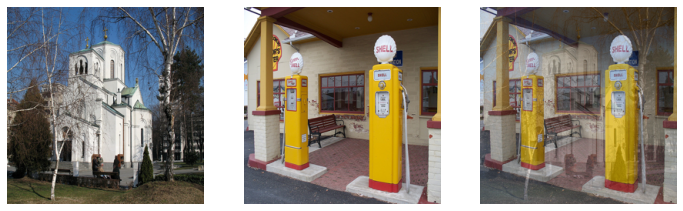

In [18]:
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[0])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);

In [19]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.899557,1.978326,0.397685,00:57
1,1.673918,1.380302,0.552651,00:57
2,1.461104,1.029827,0.682599,00:57
3,1.305250,0.787629,0.765497,00:56
4,1.189922,0.685247,0.797984,00:56


# Label Smoothing

https://arxiv.org/abs/1512.00567


In [20]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.786194,2.349882,0.418596,00:56
1,1.523597,1.473454,0.585138,00:57
2,1.282470,1.287602,0.693801,00:56
3,1.117353,1.050659,0.789768,00:56
4,1.011100,0.961787,0.834205,00:56
